In [28]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from torch.utils.data import DataLoader
from func import OR,heatplot,misorientation,classplot,ipfplot,ipfread,negsample,find_neigh,quaternion
from func2 import create_dataset
from Class import Data,Cluster,Dataset,CNN49ag,CNN49bg
import torch.nn.functional as F
import matplotlib.patches as patches
def parse(subject,src):
    output=dict()
    for i in range(len(src)):
        steel=src[i].split("/")[1]
        if steel not in output:
            output[steel]=subject[i]
        else:
            output[steel]+=subject[i]
    return output


In [2]:
model_path="model/CNN_49g_all/0.815_CNN49bg_Phase_BC_Error_Quaternion.pkl"
model_name=model_path.split("/")[-1].replace(".pkl","")
feature=model_path.replace(".pkl","").split("/")[-1].split("_")[2:]
header=['ND面硬度(Hv)', 'TD面硬度(Hv)', 'UTS strain(%)', 'UTS stress(MPa)','Total Elongation(%)', 'E(GPa)', 'Ys(Mpa)']
prop_dic=torch.load("data/properties.pkl")
h=w=499
ks=49
m1 = torch.load(model_path)
m1.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'Class.CNN49bg' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `t

CNN49bg(
  (batchnorm): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1): Conv2d(7, 12, kernel_size=(4, 4), stride=(1, 1))
  (cnn2): Conv2d(12, 18, kernel_size=(4, 4), stride=(1, 1))
  (cnn3): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [3]:
try:
    data,props,src=torch.load("data/"+model_name+"/data.pkl")
except:
    train=create_dataset("train",steels=["590","780","980"],feature=feature,prop_dic=prop_dic,pic_size=h,
                     sam_size=ks,prediction=1)
    val=create_dataset("val",steels=["590","780","980"],feature=feature,prop_dic=prop_dic,pic_size=h,
                         sam_size=ks,prediction=1)
    test=create_dataset("test",steels=["590","780","980"],feature=feature,prop_dic=prop_dic,pic_size=h,
                         sam_size=ks,prediction=1)
    data=torch.cat([train[0],val[0],test[0]])
    props=torch.cat([train[1],val[1],test[1]])
    src=train[2]+val[2]+test[2]
    os.mkdir("data/"+model_name)
    torch.save([data,props,src],"data/"+model_name+"/data.pkl")
num=data.shape[0]
try:
    pred=torch.load("data/"+model_name+"/pred.pkl")
except:
    data=data.cuda()
    props=props.cuda()
    pred=np.zeros([data.shape[0],h-ks+1,w-ks+1])
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            output=m1(data[:,:,i:i+ks,j:j+ks],props)
            for k in range(num):
                pred[k,i,j]+=output[k,0].detach().item()
            del output
    torch.save(pred,"data/"+model_name+"/pred.pkl")


In [217]:
#ferrite,martensite
prob=np.zeros([num,2]) 
pixels=np.zeros([num,2])        
for ite,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    pad=24
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            if class_map[pad+i,pad+j] in ma_id:
                prob[ite,1]+=pred[ite,i,j]
                pixels[ite,1]+=1
            else:
                prob[ite,0]+=pred[ite,i,j]
                pixels[ite,0]+=1
# print(prob/pixels)
        

In [218]:
prob=parse(prob,src)
pixels=parse(pixels,src)
result=dict()
for key in list(prob.keys()):
    result[key]=prob[key]/pixels[key]
with pd.ExcelWriter('output/MF.xlsx') as writer: 
    pd.DataFrame(prob).to_excel(writer,sheet_name='prob', index=False, header=True,float_format='%d')
    pd.DataFrame(pixels).to_excel(writer,sheet_name='pixels', index=False, header=True,float_format='%d')
    pd.DataFrame(result).to_excel(writer,sheet_name='result', index=False, header=True,float_format='%.3f')
    

In [184]:
#0 ferrite in ferrite
#1 ferrite in ferrite bd
#2 ferrite in martensite bd
#3 martensite in martensite
#4 martensite in ferrite bd

prob=np.zeros([num,5]) #ferrite,martensite
pixels=np.zeros([num,5])        
pad=24
neigh=np.array([[1,0],[-1,0],[0,1],[0,-1]])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            types=[]
            if class_map[pad+i,pad+j] in ma_id:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(3)
                    else:
                        types.append(4)
            else:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(2)
                    else:
                        if class_map[pad+i+n0,pad+j+n1]==class_map[pad+i,pad+j]:
                            types.append(0)
                        else:
                            types.append(1)
            for ele in types:
                prob[ind,ele]+=pred[ind,i,j]
                pixels[ind,ele]+=1



In [185]:
prob=parse(prob,src)
pixels=parse(pixels,src)
result=dict()
for key in list(prob.keys()):
    result[key]=prob[key]/pixels[key]
with pd.ExcelWriter('output/MFedge.xlsx') as writer: 
    pd.DataFrame(prob).to_excel(writer,sheet_name='prob', index=False, header=True,float_format='%d')
    pd.DataFrame(pixels).to_excel(writer,sheet_name='pixels', index=False, header=True,float_format='%d')
    pd.DataFrame(result).to_excel(writer,sheet_name='result', index=False, header=True,float_format='%.3f')


In [40]:
# output=torch.load("output/test_map.pkl")
# torch.save(new_map_2,"output/test_map.pkl")
# pd.DataFrame(np.array([prob.tolist(),pixels.tolist()]),columns=["f in f","f in fbd","f in mbd","m in m","m in fbd"]).to_excel("output/edge_analysis.xlsx")

In [186]:
#0 ferrite in ferrite
#1 ferrite in ferrite bd
#2 ferrite in martensite bd
#3 ferrite in martensite bd and ferrite bd
#4 martensite in martensite
#5 martensite in ferrite bd
prob=np.zeros([num,6]) #ferrite,martensite
pixels=np.zeros([num,6])        
neigh=np.array([[1,0],[-1,0],[0,1],[0,-1]])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            types=[]
            if class_map[pad+i,pad+j] in ma_id:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(4)
                    else:
                        types.append(5)
                if 5 in types:
                    prob[ind,5]+=pred[ind,i,j]
                    pixels[ind,5]+=1
                else:
                    prob[ind,4]+=pred[ind,i,j]
                    pixels[ind,4]+=1
            else:
                for (n0,n1) in neigh:
                    if class_map[pad+i+n0,pad+j+n1] in ma_id:
                        types.append(2)
                    else:
                        if class_map[pad+i+n0,pad+j+n1]==class_map[pad+i,pad+j]:
                            types.append(0)
                        else:
                            types.append(1)
                if 1 in types and 2 in types:
                    prob[ind,3]+=pred[ind,i,j]
                    pixels[ind,3]+=1
                elif 1 in types:
                    prob[ind,1]+=pred[ind,i,j]
                    pixels[ind,1]+=1
                elif 2 in types:
                    prob[ind,2]+=pred[ind,i,j]
                    pixels[ind,2]+=1
                else:
                    prob[ind,0]+=pred[ind,i,j]
                    pixels[ind,0]+=1




In [187]:
prob=parse(prob,src)
pixels=parse(pixels,src)
result=dict()
for key in list(prob.keys()):
    result[key]=prob[key]/pixels[key]
with pd.ExcelWriter('output/MFcenterpixel.xlsx') as writer: 
    pd.DataFrame(prob).to_excel(writer,sheet_name='prob', index=False, header=True,float_format='%d')
    pd.DataFrame(pixels).to_excel(writer,sheet_name='pixels', index=False, header=True,float_format='%d')
    pd.DataFrame(result).to_excel(writer,sheet_name='result', index=False, header=True,float_format='%.3f')


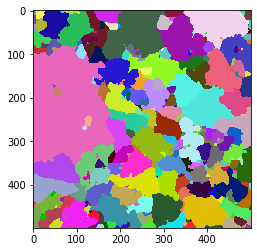

True

In [118]:
index=-1
sum_map=pred[index]
cv2.imwrite("output/20201109_451451.png",sum_map*255)
cv2.imwrite("output/20201109_451451_inv.png",(1-sum_map)*255)
class_map,id2clus,ma_id=torch.load(src[index]+"cluster.pkl")
class_img=classplot(class_map)[24:475,24:475,:]
ipf=ipfread(src[index])[24:475,24:475,6:]
cv2.imwrite("output/20201109_class.png",class_img)
cv2.imwrite("output/20201109_ipf_b.png",ipf)
for i in range(3):
    ipf[:,:,i]=np.multiply(1-sum_map,ipf[:,:,i])
    class_img[:,:,i]=np.multiply(1-sum_map,class_img[:,:,i])
cv2.imwrite("output/20201109_ipf_d.png",ipf)
cv2.imwrite("output/20201109_class_d.png",class_img)



In [7]:
crack_prop=[]
index=-2
ipf=ipfread(src[index])[24:475,24:475,6:]
cracks=dict()
outmap=np.zeros([h-ks+1,w-ks+1])
ite=1
for i in range(h-ks+1):
    for j in range(w-ks+1):
        if pred[index,i,j]>0.95:
            cracks[ite]=Cluster(ite,i,j)
            outmap[i,j]=1
            ite+=1
crack_prop.append(outmap)
cv2.imwrite("output/20211109_crack_prop/binary/%.2f.png"%(0),outmap*255)
ipf_cur=ipf.copy()
for i in range(3):
    ipf_cur[:,:,i]=np.multiply(1-outmap,ipf[:,:,i])
cv2.imwrite("output/20211109_crack_prop/IPFZ/%.2f.png"%(0),ipf_cur)
for thres in np.arange(0.01,0.06,0.01):
    for key in list(cracks.keys()):
        to_travel=cracks[key].pixels.copy()
        while len(to_travel)>0:
            i,j=to_travel.pop()
            cracks[key].add(i,j)
            for m,n in find_neigh((i,j),h-ks+1,w-ks+1):
                if pred[index,m,n]>pred[index,i,j]-thres:
                    if (m,n) not in cracks[key].pixels:
                        to_travel.add((m,n))
    outmap=np.zeros([h-ks+1,w-ks+1])
    for key in list(cracks.keys()):
        to_travel=cracks[key].pixels.copy()
        while len(to_travel)>0:
            i,j=to_travel.pop()
            outmap[i,j]=1
    crack_prop.append(outmap)
    cv2.imwrite("output/20211109_crack_prop/binary/%.2f.png"%(thres),outmap*255)
    ipf_cur=ipf.copy()
    for i in range(3):
        ipf_cur[:,:,i]=np.multiply(1-outmap,ipf[:,:,i])
    cv2.imwrite("output/20211109_crack_prop/IPFZ/%.2f.png"%(thres),ipf_cur)

    

In [223]:
interval=np.arange(0.9,1.001,0.001)
num_phase=np.zeros([len(src),len(interval),2]) #ferrite,martensite
pixels=np.zeros([len(src),2])
for ind,path in enumerate(src):
    class_map,id2clus,ma_id=torch.load(path+"cluster.pkl")
    cur_map=pred[ind]
    for i in range(h-ks+1):
        for j in range(w-ks+1):
            if class_map[pad+i,pad+j] in ma_id:
                pixels[ind,1]+=1
            else:
                pixels[ind,0]+=1
    for ite,ele in enumerate(interval):
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                if cur_map[i,j]>=ele:
                    if class_map[pad+i,pad+j] in ma_id:
                        num_phase[ind,ite,1]+=1
                    else:
                        num_phase[ind,ite,0]+=1                        
pixels=parse(pixels,src)
num_phase=parse(num_phase,src)
result=dict()
for key in list(pixels.keys()):
    result[key]=num_phase[key]/pixels[key]
            

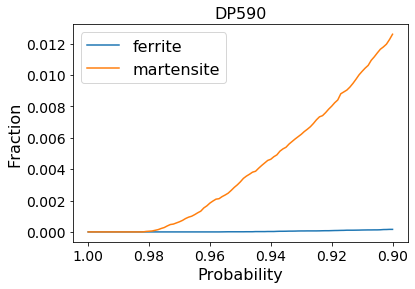

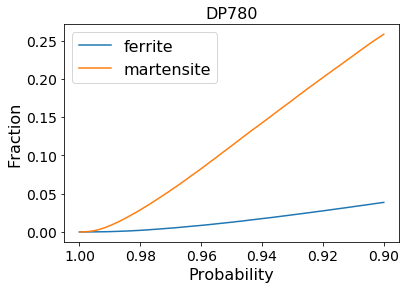

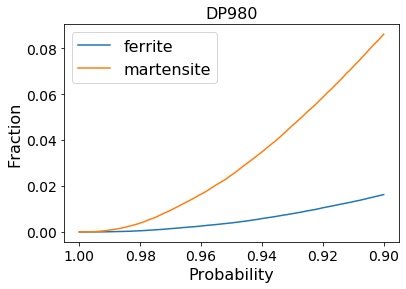

In [224]:
for steel in ["590","780","980"]:
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Probability",fontsize=16)
    plt.ylabel('Fraction',fontsize=16)
    plt.title("DP"+steel,fontsize=16)
    p1,=plt.plot(interval,result[steel][:,0])
    p2,=plt.plot(interval,result[steel][:,1])
    ax = p1.axes
    ax.invert_xaxis()
    plt.legend([p1,p2],["ferrite","martensite"],fontsize=16)
    plt.savefig("output/fraction/%s_0.9_1.png"%(steel),dpi=600,bbox_inches='tight', pad_inches=0.2)
    plt.show()


In [17]:
data[-2]

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         ...,
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00]],

        [[ 1.3400e+02,  1.4500e+02,  1.3900e+02,  ...,  1.2400e+02,
           1.0600e+02,  1.0500e+02],
         [ 1.4000e+02,  1.4200e+02,  1.4700e+02,  ...,  1.0200e+02,
           9.1000e+01,  1.0300e+02],
         [ 1.4800e+02,  1.4500e+02,  1.4300e+02,  ...,  1.2900e+02,
           9.7000e+01,  1.2600e+02],
         ...,
         [ 1.3700e+02,  1

In [37]:
change=[]
min_set={"Phase","BC"}

for i,ele in enumerate(feature):
    if ele in min_set:
        change.append(torch.min(data[:,i]))
    elif ele=="Quaternion":
        change=change+[1,0,0,0]
    else:
        change.append(torch.max(data[:,i]))
        
        
